<a href="https://colab.research.google.com/github/nikolasjdawson/job_ads_forecasting/blob/master/AUS_Job_Ads_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 545kB/s 
     |████████████████████████████████| 3.1MB 31.3MB/s 
     |████████████████████████████████| 501kB 47.5MB/s 
  Found existing installation: tensorflow 1.15.0rc3
    Uninstalling tensorflow-1.15.0rc3:
      Successfully uninstalled tensorflow-1.15.0rc3


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
# Create a helper function to plot the series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
# Use following function to upload data files
from google.colab import files
uploaded = files.upload()

Saving AUS_job_ads_daily.csv to AUS_job_ads_daily.csv


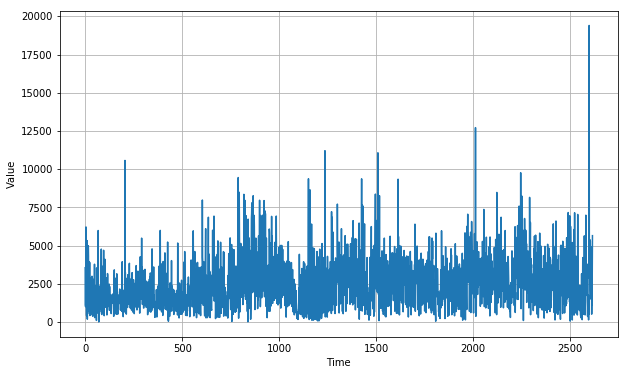

In [5]:
import csv
# Store the data in numpy lists.
# The row integer references are used as time steps (not the dates)
time_step = []
job_ads = []

with open('AUS_job_ads_daily.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  # Skip the header row
  next(reader)
  step=0
  for row in reader:
    # convert each temp into a float
    job_ads.append(int(row[1]))
    time_step.append(step)
    step = step + 1

# Save the lists into numpy arrays and plot to visualise
series = np.array(job_ads)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
# Designate the split time. This split uses the last 365 days as validation.
split_time = 2251
# Specify the training set
time_train = time[:split_time]
x_train = series[:split_time]
# Specify the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# Set the constants. 
# It can be good to make the window and batch sizes divisible by the time length.
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
len(time)

2616

In [0]:
# Define the window function.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
# Define the model forecast function.
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.int64, tf.int64)>
(2251,)
Epoch 1/100
9/9 [==============================] - 6s 706ms/step - loss: 2526.8720 - mae: 2514.5405
Epoch 2/100
9/9 [==============================] - 4s 410ms/step - loss: 2524.1498 - mae: 2513.1201
Epoch 3/100
9/9 [==============================] - 4s 413ms/step - loss: 2521.9499 - mae: 2510.9326
Epoch 4/100
9/9 [==============================] - 4s 411ms/step - loss: 2519.2101 - mae: 2508.1985
Epoch 5/100
9/9 [==============================] - 4s 412ms/step - loss: 2516.1588 - mae: 2505.1531
Epoch 6/100
9/9 [==============================] - 4s 413ms/step - loss: 2512.7863 - mae: 2501.7876
Epoch 7/100
9/9 [==============================] - 4s 411ms/step - loss: 2509.1110 - mae: 2498.1184
Epoch 8/100
9/9 [==============================] - 4s 410ms/step - loss: 2505.0486 - mae: 2494.0662
Epoch 9/

[1e-08, 0.0001, 1000, 2700]

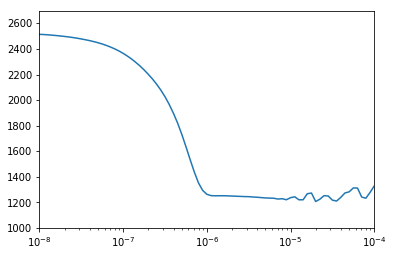

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 1000, 2700])

The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. 

The learning rate may be the most important hyperparameter when configuring your neural network. 

Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.

## Learning Rate Schedule

The way in which the learning rate changes over time (training epochs) is referred to as the learning rate schedule or learning rate decay.

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# We can see from above that performance begins to deteriorate at lr=1e-5
# So try lr=1e-6
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
# Increase epochs to 150
history = model.fit(train_set,epochs=150)

Epoch 1/150
22/22 [==============================] - 6s 278ms/step - loss: 2442.4839 - mae: 2442.4680
Epoch 2/150
22/22 [==============================] - 3s 150ms/step - loss: 2135.6090 - mae: 2135.7671
Epoch 3/150
22/22 [==============================] - 3s 151ms/step - loss: 1763.3179 - mae: 1763.6779
Epoch 4/150
22/22 [==============================] - 3s 152ms/step - loss: 1396.5171 - mae: 1396.8529
Epoch 5/150
22/22 [==============================] - 3s 150ms/step - loss: 1251.5079 - mae: 1251.7208
Epoch 6/150
22/22 [==============================] - 3s 152ms/step - loss: 1247.2716 - mae: 1247.5168
Epoch 7/150
22/22 [==============================] - 3s 153ms/step - loss: 1248.4125 - mae: 1248.6548
Epoch 8/150
22/22 [==============================] - 3s 151ms/step - loss: 1246.4265 - mae: 1246.6608
Epoch 9/150
22/22 [==============================] - 3s 152ms/step - loss: 1244.2391 - mae: 1244.4713
Epoch 10/150
22/22 [==============================] - 3s 154ms/step - loss: 1241.3

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

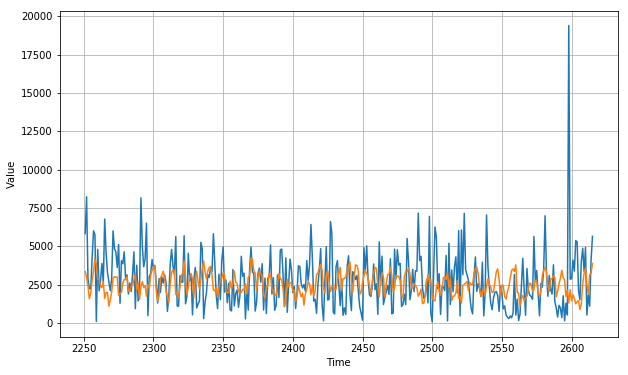

In [18]:
# Plot forecasts vs actuals for validation set
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [19]:
# Get MAE metric
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1383.619

In [20]:
# The array of forecast values for the validation set.
print(rnn_forecast)

[3353.995  2988.6316 2420.442  1581.4539 1971.5471 2776.349  3404.4543
 4182.5176 3790.8965 2866.0242 2803.258  2432.5237 2309.1218 2690.8242
 1610.0044 1998.546  1993.6638 1102.8352 1494.837  2033.6477 2930.215
 3024.644  2993.6174 3006.4688 1803.6509 1903.7506 1992.174  2603.8389
 2845.1577 2828.4265 3027.581  2078.6965 2098.768  2436.972  2475.464
 2829.8845 3219.4175 2161.148  2627.3938 1549.0879 2344.3447 2708.9243
 2318.2864 2433.8828 1748.3256 2499.783  2264.5286 3116.479  3443.4854
 3620.1538 3736.2122 2109.0234 1449.0249 1782.702  2938.9495 3126.6694
 3381.1436 2877.465  2092.7336 1725.0421 1327.7045 2548.959  3266.0447
 3491.5237 3408.8262 1871.935  1959.3107 1697.0093 2337.5745 3112.9983
 3252.0745 4045.3083 2991.6538 1867.0962 2336.64   3051.6409 3230.5393
 2879.763  1654.465  2936.14   3380.7646 2669.2395 2213.9062 2858.16
 3534.8171 4044.9456 3331.1394 2880.8564 3396.7773 3617.916  3686.1436
 3146.4062 2145.7932 2103.682  2302.8696 1666.427  2374.2185 2813.866
 2911.0369 